In [1]:
import pandas as pd
import numpy as np
import venn

In [2]:
# gene uniprot ID -> reactome pathway ID (pathway membership)
uni2rea             = pd.read_csv(f'../../../data/UniProt2Reactome_All_Levels.txt', sep='\t', header=None, low_memory=False, dtype=str)
uni2rea.columns     = ['uniprot', 'pathway', 'source', 'description', 'acc', 'species']
uni2rea             = uni2rea[lambda x: ~x.pathway.isna()]
uni2rea.pathway     = [str(p) for p in uni2rea.pathway]
uni2rea             = uni2rea[lambda x: (x.species == 'Homo sapiens')]
uni2rea             = {uni:rea for uni,rea in zip(uni2rea.uniprot.values, uni2rea.pathway.values)}

uni2id = pd.read_csv('../../extdata/omnipath_uniprot2geneid.tsv', sep='\t').rename({'From':'uniprot', 'To':'gene_id'}, axis=1)
uni2symb = pd.read_csv('../../extdata/omnipath_uniprot2genesymb.tsv', sep='\t').rename({'From':'uniprot', 'To':'gene_symbol'}, axis=1)
gene_map = uni2id.merge(uni2symb, on='uniprot', how='outer')
geneinfo = pd.read_csv(f'../../../data/geneinfo_beta.txt', sep='\t')

In [3]:
clue = pd.read_csv(f'../../../data/compoundinfo_beta.txt', sep='\t')
clue_drug_target_symbols = clue.target.unique()
gene2uni = gene_map[['uniprot', 'gene_symbol']]
clue = clue.merge(gene2uni, left_on='target', right_on='gene_symbol', how='inner') 
clue = clue[['pert_id', 'uniprot', 'moa']].rename({'uniprot':'target'}, axis=1)
clue = clue.assign(combined_score=1000, source='clue')
clue.head()

,pert_id,target,moa,combined_score,source
0,BRD-A50311610,Q14994,CAR agonist,1000,clue
1,BRD-K30743633,Q14994,CAR agonist,1000,clue
2,BRD-K39381259,Q04771,ALK inhibitor,1000,clue
3,BRD-K43002773,Q9Y243,Akt inhibitor,1000,clue
4,BRD-K43002773,P31749,Akt inhibitor,1000,clue


In [4]:
stitch = pd.read_csv('../../extdata/processed_stitch_targets.csv')
stitch = stitch.assign(source='stitch', moa='')
stitch.head() 

,pert_id,target,combined_score,source,moa
0,BRD-K11267252,P07949,800,stitch,
1,BRD-K11267252,Q9UM73,968,stitch,
2,BRD-K11267252,P40763,815,stitch,
3,BRD-K94293891,O43614,962,stitch,
4,BRD-K94293891,O43613,971,stitch,


In [5]:
targ = pd.read_csv('../../extdata/targetome_with_broad_ids.csv')
targ = targ.rename({'Target_UniProt':'target'}, axis=1)
targ = targ.assign(combined_score = 1000, source='targetome', moa='')
targ = targ[['pert_id','target','combined_score','moa','source']]
targ.head() 

,pert_id,target,combined_score,moa,source
0,BRD-K24048528,P05093,1000,,targetome
1,BRD-K24048528,P08684,1000,,targetome
2,BRD-K24048528,P15538,1000,,targetome
3,BRD-K24048528,P19099,1000,,targetome
4,BRD-K11267252,Q9UM73,1000,,targetome


In [6]:
targ2 = pd.read_csv('../../extdata/targetome_expanded_beta.csv')
targ2 = targ2[['pert_id', 'uniprot_id']].assign(combined_score=1000, source='targetome_expanded', moa='')
targ2 = targ2.rename({'uniprot_id':'target'}, axis=1)
targ2.head()

,pert_id,target,combined_score,source,moa
0,BRD-A00546892,P08912,1000,targetome_expanded,
1,BRD-A00546892,P11229,1000,targetome_expanded,
2,BRD-A00546892,P20309,1000,targetome_expanded,
3,BRD-A00993607,P07550,1000,targetome_expanded,
4,BRD-A00993607,P08588,1000,targetome_expanded,


In [7]:
print(f'# of DTIs in clue: {clue.target.shape[0]}')
print(f'# of DTIs in stitch: {stitch.target.shape[0]}')
print(f'# of DTIs in targetome: {targ.target.shape[0]}')
print(f'# of DTIs in targetome_expanded: {targ2.target.shape[0]}')

# of DTIs in clue: 7981
# of DTIs in stitch: 97355
# of DTIs in targetome: 839
# of DTIs in targetome_expanded: 2091


In [8]:
druginfo = pd.concat((clue, stitch, targ, targ2), axis=0)
druginfo = druginfo.groupby(['pert_id', 'target']).agg({'combined_score' : np.mean, "moa" : lambda x: ' |AND| '.join(np.unique(x)), 'source':lambda x: '+'.join(np.unique(x))}).reset_index()



/tmp/ipykernel_22026/3778333211.py:2: FutureWarning: The provided callable <function mean at 0x7fe2a06b6520> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  druginfo = druginfo.groupby(['pert_id', 'target']).agg({'combined_score' : np.mean, "moa" : lambda x: ' |AND| '.join(np.unique(x)), 'source':lambda x: '+'.join(np.unique(x))}).reset_index()


In [9]:
druginfo = druginfo.assign(in_stitch=lambda x: x.source.str.contains('stitch'), 
                in_targetome=lambda x: x.source.str.contains('targetome') & ~x.source.str.contains('targetome_expanded'),
                in_targetome_expanded=lambda x: x.source.str.contains('targetome_expanded'),
                in_clue=lambda x: x.source.str.contains('clue'))
druginfo.head()

,pert_id,target,combined_score,moa,source,in_stitch,in_targetome,in_targetome_expanded,in_clue
0,BRD-A00077618,O60603,800.0,,stitch,True,False,False,False
1,BRD-A00077618,P00797,818.0,,stitch,True,False,False,False
2,BRD-A00077618,P01112,800.0,,stitch,True,False,False,False
3,BRD-A00077618,P03956,800.0,,stitch,True,False,False,False
4,BRD-A00077618,P05019,786.0,,stitch,True,False,False,False


In [10]:
druginfo.to_csv('../../extdata/processed_targets.csv', index=False)

In [11]:
print(f'# of unique drugs: {druginfo.pert_id.nunique()}')
print(f'# of unique targets: {druginfo.target.nunique()}')
print(f'# of unique target-drug pairs: {druginfo.shape[0]}')

# of unique drugs: 4728
# of unique targets: 8219
# of unique target-drug pairs: 95068


In [12]:
druginfo.groupby('source').count()[['pert_id']].rename({'pert_id':'count'}, axis=1).sort_values('count', ascending=False)

,count
source,
stitch,87121
clue+stitch,2999
clue,2077
stitch+targetome_expanded,719
targetome_expanded,649
clue+stitch+targetome_expanded,558
targetome,471
stitch+targetome,242
clue+targetome_expanded,106


<Axes: >

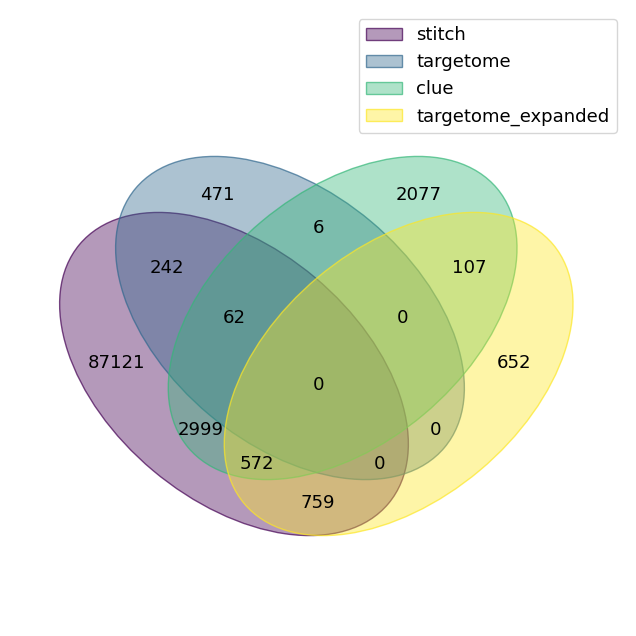

In [13]:

druginfo2 = druginfo.assign(dti_key = lambda x: x.pert_id + '_' + x.target)
A = set(druginfo2[lambda x: x.in_stitch].dti_key.values.tolist())
B = set(druginfo2[lambda x: x.in_targetome].dti_key.values.tolist())
C = set(druginfo2[lambda x: x.in_clue].dti_key.values.tolist())
D = set(druginfo2[lambda x: x.in_targetome_expanded].dti_key.values.tolist())

subsets = {'stitch':A, 'targetome':B, 'clue':C, 'targetome_expanded':D}

venn.venn(subsets)